# Figure 5. Compared with other VEPs.

## 1 Draw AUC

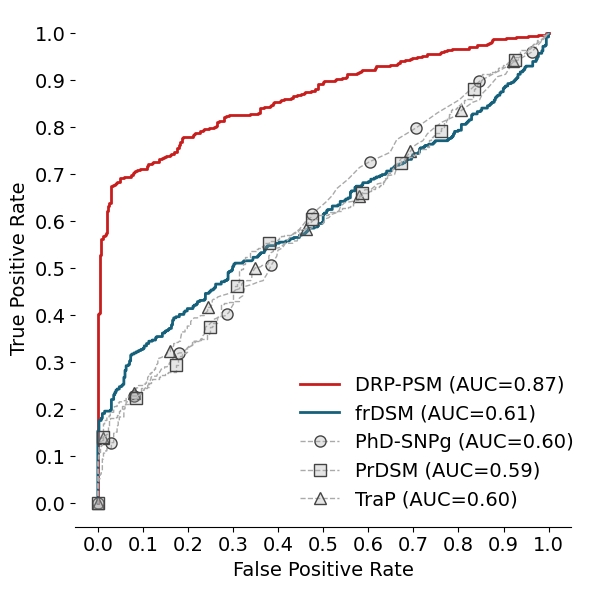

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib.colors import to_rgba

# Load data
df = pd.read_csv("../data/test816_random_10methods.csv")
hdpsm_pred = pd.read_csv("../../DNA_RNA_Protein/step2-result/test816_predicted_imputed.csv", usecols=['Variant_hg19', 'HDPSM'])
result_df = df.merge(hdpsm_pred, how='left', left_on='Variant_hg19', right_on='Variant_hg19', suffixes=('', '_m'))
result_df.rename(columns={'TraP3': 'TraP', 'HDPSM': 'DRP-PSM'}, inplace=True)
result_df = result_df.iloc[:, 8:]

# Group data
all_methods = result_df.columns.drop('label')
methods_with_nan = [col for col in all_methods if result_df[col].isnull().any() and col != 'DRP-PSM']
methods_no_nan = [col for col in all_methods if not result_df[col].isnull().any() and col != 'DRP-PSM']

def plot_group_auc(df, methods, save_name):
    selected_methods = methods + ['DRP-PSM']
    data = df[['label'] + selected_methods].dropna()

    # 1 calculate by auc
    auc_scores = {}
    roc_data = {}
    for method in selected_methods:
        y_true = data['label'].astype(int)
        y_score = data[method].astype(float)
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        auc_scores[method] = roc_auc
        roc_data[method] = (fpr, tpr)

    # 2 rank by auc
    sorted_auc = sorted(auc_scores.items(), key=lambda x: x[1], reverse=True)
    best = sorted_auc[0][0]
    second_best = sorted_auc[1][0] if len(sorted_auc) > 1 else None

    # 3 Set color, linestyle, marker
    colors = {m: '#AAA' for m in selected_methods}
    colors[best] = '#c71e1d'
    if second_best:
        colors[second_best] = '#15607a'
    
    linestyles = {m: '-' if m in [best, second_best] else '--' for m in selected_methods}
    markers = ['o', 's', '^', 'D', '>', 'P']
    marker_map = {m: markers[i % len(markers)] if m not in [best, second_best] else None 
                  for i, m in enumerate(selected_methods)}

    # 4 plot
    plt.figure(figsize=(6, 6))
    for m, _ in sorted_auc:
        fpr, tpr = roc_data[m]
        marker = marker_map[m]
        if marker:
            plt.plot(fpr, tpr, 
                    color=colors[m], 
                    linestyle=linestyles[m],
                    marker=marker, 
                    markevery=0.1, 
                    markersize=8,
                    markerfacecolor=to_rgba(colors[m], alpha=0.3),
                    markeredgecolor='#444',
                    label=f'{m} (AUC={auc_scores[m]:.2f})',
                    linewidth=1)
        else:
            plt.plot(fpr, tpr,
                    color=colors[m],
                    linestyle=linestyles[m],
                    label=f'{m} (AUC={auc_scores[m]:.2f})',
                    linewidth=2)
    # sort handles and labels alphabetically by method name (case-insensitive)
    handles, labels = plt.gca().get_legend_handles_labels()
    sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0].lower())
    labels, handles = zip(*sorted_pairs)
    plt.legend(handles, labels, loc='lower right',  bbox_to_anchor=(1.04, 0), ncol=1, frameon=False, fontsize=14)

    plt.xlabel('False Positive Rate', fontsize=14, fontfamily='DejaVu Sans')
    plt.ylabel('True Positive Rate', fontsize=14, fontfamily='DejaVu Sans')
    plt.xticks(np.arange(0, 1.1, 0.1), fontsize=14, fontfamily='DejaVu Sans')
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14, fontfamily='DejaVu Sans')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', left=True)
    plt.tight_layout()
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

# plot for method with nan value
plot_group_auc(result_df, methods_with_nan, './Figure5A.png')

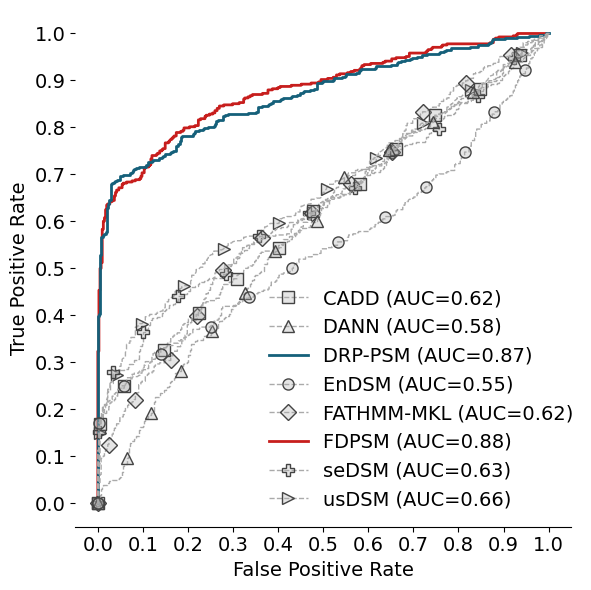

In [ ]:
# plot for method with No nan value
plot_group_auc(result_df, methods_no_nan, './Figure5C.png')

## 2 Draw AUPR

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score
from matplotlib.colors import to_rgba

def plot_group_aupr(df, methods, save_name):
    selected_methods = methods + ['DRP-PSM']
    data = df[['label'] + selected_methods].dropna()

    # 1 calculate by au
    aupr_scores = {}
    pr_data = {}
    for method in selected_methods:
        y_true = data['label'].astype(int)
        y_score = data[method].astype(float)
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        aupr = average_precision_score(y_true, y_score)
        aupr_scores[method] = aupr
        pr_data[method] = (recall, precision)

    # 2 rank by auc
    sorted_aupr = sorted(aupr_scores.items(), key=lambda x: x[1], reverse=True)
    best = sorted_aupr[0][0]
    second_best = sorted_aupr[1][0] if len(sorted_aupr) > 1 else None

    # 3 Set color, linestyle, marker
    colors = {m: '#AAA' for m in selected_methods}
    colors[best] = '#c71e1d'
    if second_best:
        colors[second_best] = '#15607a'

    linestyles = {m: '-' if m in [best, second_best] else '--' for m in selected_methods}
    markers = ['o', 's', '^', 'D', '>', 'P']
    marker_map = {m: markers[i % len(markers)] if m not in [best, second_best] else None 
                  for i, m in enumerate(selected_methods)}

    # 4 plot
    plt.figure(figsize=(6, 6))
    for m, _ in sorted_aupr:
        recall, precision = pr_data[m]
        marker = marker_map[m]
        if marker:
            plt.plot(recall, precision,
                     color=colors[m],
                     linestyle=linestyles[m],
                     marker=marker,
                     markevery=0.1,
                     markersize=8,
                     markerfacecolor=to_rgba(colors[m], alpha=0.3),
                     markeredgecolor='#444',
                     label=f'{m} (AUPR={aupr_scores[m]:.2f})',
                     linewidth=1)
        else:
            plt.plot(recall, precision,
                     color=colors[m],
                     linestyle=linestyles[m],
                     label=f'{m} (AUPR={aupr_scores[m]:.2f})',
                     linewidth=2)

    # sort handles and labels alphabetically by method name (case-insensitive)
    handles, labels = plt.gca().get_legend_handles_labels()
    sorted_pairs = sorted(zip(labels, handles), key=lambda x: x[0].lower())
    labels, handles = zip(*sorted_pairs)
    plt.legend(handles, labels, loc='lower left', ncol=1, frameon=False, fontsize=14)
    plt.xlabel('Recall', fontsize=14, fontfamily='DejaVu Sans')
    plt.ylabel('Precision', fontsize=14, fontfamily='DejaVu Sans')
    plt.xticks(np.arange(0, 1.1, 0.1), fontsize=14, fontfamily='DejaVu Sans')
    plt.yticks(np.arange(0, 1.1, 0.1), fontsize=14, fontfamily='DejaVu Sans')

    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(axis='y', left=True)
    plt.tight_layout()
    plt.savefig(save_name, bbox_inches='tight')
    plt.show()

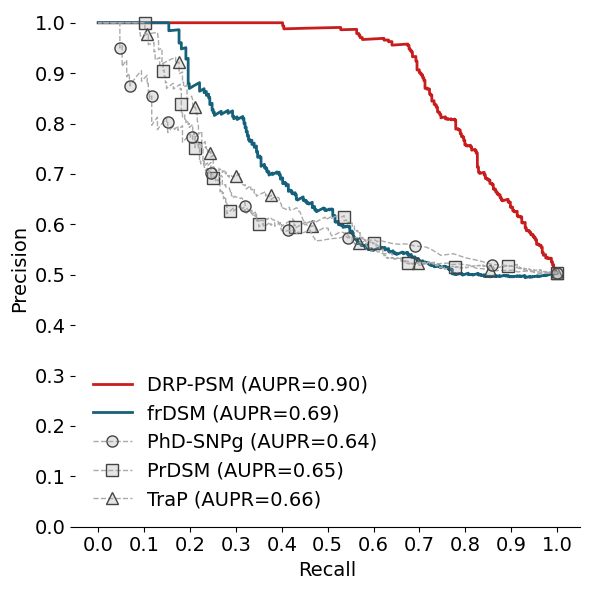

In [ ]:
plot_group_aupr(result_df, methods_with_nan, './Figure5B.png')

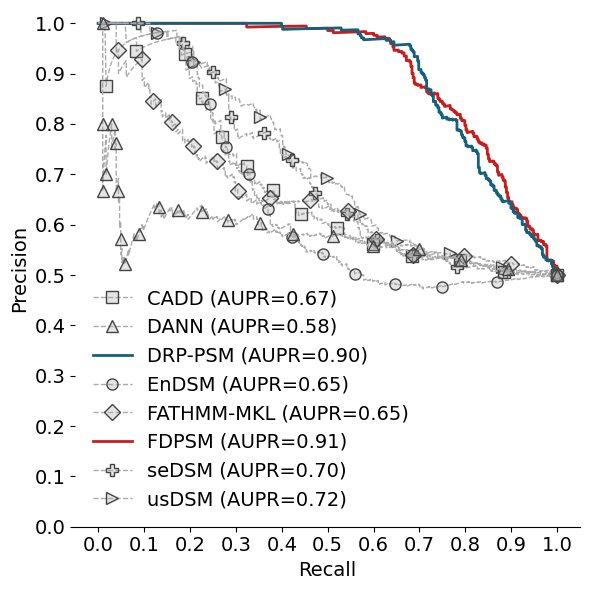

In [ ]:
plot_group_aupr(result_df, methods_no_nan, './Figure5D.png')